Imports

In [1]:
import math
import numpy as np
import tensorflow
from tensorflow.keras.datasets import mnist, cifar10, fashion_mnist, cifar100

In [2]:
from tensorflow.keras.utils import to_categorical

Load CIFAR100 Data

In [ ]:
(training_data,training_labels),(testing_data,testing_labels) = cifar100.load_data()

169001437/169001437 [==============================] - 6s 0us/step


In [ ]:
print(training_data.shape,training_labels.shape,testing_data.shape,testing_labels.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


Use 25% of data for hyper-parameter tuning

In [ ]:
training_data = training_data[:12500,:,:]
training_labels = training_labels[:12500]
testing_data = testing_data[:2500,:,:]
testing_labels = testing_labels[:2500]
print(training_data.shape,training_labels.shape,testing_data.shape,testing_labels.shape)

(12500, 32, 32, 3) (12500, 1) (2500, 32, 32, 3) (2500, 1)


Pre-processing

In [ ]:
# Normalization - check min and max
print(np.min(training_data), np.max(training_data))
print(np.min(testing_data), np.max(testing_data))

0 255
0 255


In [ ]:
training_data = training_data.astype('float32') /255.0
testing_data = testing_data.astype('float32') / 255.0

In [ ]:
from tensorflow.keras.utils import to_categorical

nclasses = 100

# One-hot encoding for the numeric labels
training_labels = to_categorical(training_labels,num_classes=nclasses)
testing_labels = to_categorical(testing_labels,num_classes=nclasses) 

Dividing the training data to get validation set

In [ ]:
divide = int(0.1*training_data.shape[0]) # 90-10 split between training and validation sets
X_train = training_data[divide:]
X_validate = training_data[:divide]
Y_train = training_labels[divide:]
Y_validate = training_labels[:divide]
print(X_train.shape,X_validate.shape,Y_train.shape,Y_validate.shape)

(11250, 32, 32, 3) (1250, 32, 32, 3) (11250, 100) (1250, 100)


Implementation of GoogleNet(Inception) Architecture

In [3]:
from tensorflow.keras.layers import Dense, Conv2D, Input, MaxPool2D, Flatten, Dropout, BatchNormalization, AveragePooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers

class GoogleNet:

    def __init__(self, nclasses=10) -> None:
       
        self.nclasses = nclasses
        self.input_layer = Input(shape=(training_data.shape[1],training_data.shape[2],training_data.shape[3]))

        convolution_1_layer = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(self.input_layer)
        maxpool_1_layer = MaxPool2D(pool_size=(3,3), strides=2, padding='same')(convolution_1_layer)
        norm_1_layer = BatchNormalization()(maxpool_1_layer)

        reduct_layer = Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same', activation='relu')(norm_1_layer)
        convolution_2_layer = Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same', activation='relu')(reduct_layer)
        norm_2_layer = BatchNormalization()(convolution_2_layer)
        maxpool_2_layer = MaxPool2D(pool_size=(3,3), strides=2, padding='same')(norm_2_layer)

        inception_3a_layer = self.inception_module(maxpool_2_layer, [64,128,32])
        inception_3b_layer = self.inception_module(inception_3a_layer, [128,192,96])
        maxpool_3_layer = MaxPool2D(pool_size=(3,3), strides=2, padding='same')(inception_3b_layer)

        inception_4a_layer = self.inception_module(maxpool_3_layer, [192,208,48])
        self.aux1_layer = self.auxilary_module(inception_4a_layer, 'aux1')
        inception_4b_layer = self.inception_module(inception_4a_layer, [160,224,64])
        inception_4c_layer = self.inception_module(inception_4b_layer, [128,256,64])
        inception_4d_layer = self.inception_module(inception_4c_layer, [112,288,64])
        inception_4e_layer = self.inception_module(inception_4d_layer, [256,320,128])
        self.aux2_layer = self.auxilary_module(inception_4e_layer, 'aux2')
        maxpool_4_layer = MaxPool2D(pool_size=(3,3), strides=2, padding='same')(inception_4e_layer)

        inception_5a_layer = self.inception_module(maxpool_4_layer, [256,320,128])
        inception_5b_layer = self.inception_module(inception_5a_layer, [384,384,128])
        avgpool_layer = AveragePooling2D(pool_size=(7,7), strides=1, padding='same')(inception_3b_layer)

        fc_layer = Flatten()(avgpool_layer)
        dropout_layer = Dropout(rate=0.4)(fc_layer)

        self.output_layer = Dense(units=nclasses, activation='softmax')(dropout_layer)

        self.model = Model(inputs=self.input_layer, outputs=[self.output_layer,self.aux1_layer,self.aux2_layer])
    
    def inception_module(self, layer, filterList):
        # Inception without dimension reduction
        reduct = Conv2D(filters=filterList[0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
        conv_1 = Conv2D(filters=filterList[1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(layer)
        conv_2 = Conv2D(filters=filterList[1], kernel_size=(5,5), strides=1, padding='same', activation='relu')(layer)
        maxpool = MaxPool2D(pool_size=(3,3),strides=1,padding='same')(layer)
        return Concatenate(axis=-1,)([reduct,conv_1,conv_2,maxpool])
    
    def auxilary_module(self, layer, name):
        # Occurs right after Inception Layers 4a and 4d
        avg = AveragePooling2D(pool_size=(5,5), strides=3, padding='same')(layer)
        reduct = Conv2D(filters=128, kernel_size=(1,1), strides=1, padding='same', activation='relu')(avg)
        fc = Flatten()(reduct)
        fc = Dense(units=1024, activation='relu')(fc)
        dropout = Dropout(rate=0.7)(fc)
        return Dense(units=self.nclasses, activation='softmax', name=name)(dropout)

In [ ]:
model_hpt_epoch = GoogleNet(nclasses=nclasses).model
model_hpt_epoch.compile(
    optimizer=optimizers.SGD(
        learning_rate=0.01,
        momentum=0.9
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)
model_hpt_epoch.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_33 (Conv2D)             (None, 16, 16, 64)   9472        ['input_3[0][0]']                
                                                                                                  
 max_pooling2d_13 (MaxPooling2D  (None, 8, 8, 64)    0           ['conv2d_33[0][0]']              
 )                                                                                                
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 8, 8, 64)    256         ['max_pooling2d_13[0][0]']   

In [4]:
batch_size = 256

In [ ]:
train_hist = []

In [ ]:
hist = model_hpt_epoch.fit(x=X_train, y=[Y_train,Y_train,Y_train], validation_data=(X_validate,[Y_validate,Y_validate,Y_validate]), epochs=50, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/50
44/44 [==============================] - 69s 1s/step - loss: 20.8540 - dense_5_loss: 11.5618 - aux1_loss: 4.6536 - aux2_loss: 4.6386 - dense_5_accuracy: 0.0168 - aux1_accuracy: 0.0141 - aux2_accuracy: 0.0108 - val_loss: 32.0848 - val_dense_5_loss: 22.8867 - val_aux1_loss: 4.5940 - val_aux2_loss: 4.6041 - val_dense_5_accuracy: 0.0088 - val_aux1_accuracy: 0.0184 - val_aux2_accuracy: 0.0160
Epoch 2/50
44/44 [==============================] - 20s 453ms/step - loss: 16.6711 - dense_5_loss: 7.4982 - aux1_loss: 4.5769 - aux2_loss: 4.5959 - dense_5_accuracy: 0.0220 - aux1_accuracy: 0.0182 - aux2_accuracy: 0.0144 - val_loss: 15.4714 - val_dense_5_loss: 6.3009 - val_aux1_loss: 4.5770 - val_aux2_loss: 4.5935 - val_dense_5_accuracy: 0.0144 - val_aux1_accuracy: 0.0184 - val_aux2_accuracy: 0.0152
Epoch 3/50
44/44 [==============================] - 20s 457ms/step - loss: 15.9387 - dense_5_loss: 6.7749 - aux1_loss: 4.5680 - aux2_loss: 4.5957 - dense_5_accuracy: 0.0341 - aux1_accuracy: 0.019

In [5]:
import matplotlib.pyplot as plt

def showLossAccPlots2(train_hist, d=5):
    
    training_acc = []
    validate_acc = []
    output_losses = []
    aux1_losses = []
    aux2_losses = []

    ol = 'dense_'+str(d)+'_loss'
    ta='dense_'+str(d)+'_accuracy'
    va='val_dense_'+str(d)+'_accuracy'
    
    for th in train_hist:
        output_losses += th.history[ol]
        aux1_losses += th.history['aux1_loss']
        aux2_losses += th.history['aux2_loss']
        training_acc += th.history[ta]
        validate_acc += th.history[va]
    
    fig, (ax1, ax2) = plt.subplots(2, 1)

    epochs = range(1, len(training_acc) + 1)

    fig.suptitle('Losses and Accuracies across epochs')

    ax1.plot(epochs, output_losses, 'b', label='Output Loss')
    ax1.plot(epochs, aux1_losses, 'y', label='Aux1 Loss')
    ax1.plot(epochs, aux2_losses, 'g', label='Aux2 Loss')
    ax1.set_ylabel('Losses')
    ax1.legend()

    ax2.plot(epochs, training_acc, 'b', label='Train accuracy')
    ax2.plot(epochs, validate_acc, 'r', label='Validate accuracy')
    ax2.set_xlabel('epochs')
    ax2.set_ylabel('Accuracies')
    ax2.legend()

    plt.show()


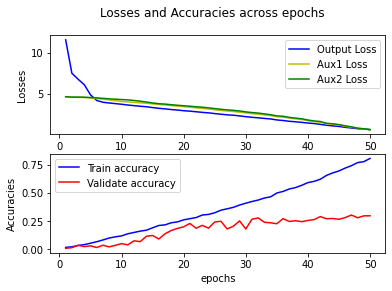

In [ ]:
showLossAccPlots2(train_hist)

As we can see, beyond 20 epcohs, validation accuracy begins to fluctuate a lot. In fact, training accuracy continues to significantly increase, which suggests overfitting. Hence, we set the number of epochs = 20.

In [6]:
epochs = 20

In [ ]:
learning_rates = [0.001, 0.01, 0.1]

model_hpt_lr0 = GoogleNet(nclasses=nclasses).model
model_hpt_lr0.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rates[0],
        momentum=0.9
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)

In [ ]:
train_hist = []
hist = model_hpt_lr0.fit(x=X_train, y=[Y_train,Y_train,Y_train], validation_data=(X_validate,[Y_validate,Y_validate,Y_validate]), epochs=epochs, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/20
44/44 [==============================] - 23s 483ms/step - loss: 15.2701 - dense_8_loss: 5.8929 - aux1_loss: 4.7129 - aux2_loss: 4.6644 - dense_8_accuracy: 0.0259 - aux1_accuracy: 0.0100 - aux2_accuracy: 0.0105 - val_loss: 13.7961 - val_dense_8_loss: 4.5856 - val_aux1_loss: 4.6054 - val_aux2_loss: 4.6051 - val_dense_8_accuracy: 0.0112 - val_aux1_accuracy: 0.0144 - val_aux2_accuracy: 0.0168
Epoch 2/20
44/44 [==============================] - 20s 464ms/step - loss: 13.8811 - dense_8_loss: 4.6871 - aux1_loss: 4.5945 - aux2_loss: 4.5995 - dense_8_accuracy: 0.0492 - aux1_accuracy: 0.0134 - aux2_accuracy: 0.0140 - val_loss: 13.7231 - val_dense_8_loss: 4.5158 - val_aux1_loss: 4.6031 - val_aux2_loss: 4.6042 - val_dense_8_accuracy: 0.0288 - val_aux1_accuracy: 0.0152 - val_aux2_accuracy: 0.0128
Epoch 3/20
44/44 [==============================] - 20s 457ms/step - loss: 13.5819 - dense_8_loss: 4.4132 - aux1_loss: 4.5822 - aux2_loss: 4.5866 - dense_8_accuracy: 0.0660 - aux1_accuracy: 0.01

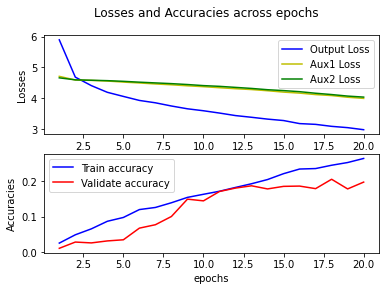

In [ ]:
showLossAccPlots2(train_hist, d=8)

In [ ]:
model_hpt_lr1 = GoogleNet(nclasses=nclasses).model
model_hpt_lr1.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rates[1],
        momentum=0.9
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)

In [ ]:
train_hist = []
hist = model_hpt_lr1.fit(x=X_train, y=[Y_train,Y_train,Y_train], validation_data=(X_validate,[Y_validate,Y_validate,Y_validate]), epochs=epochs, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/20
44/44 [==============================] - 23s 480ms/step - loss: 21.9538 - dense_11_loss: 12.6900 - aux1_loss: 4.6286 - aux2_loss: 4.6352 - dense_11_accuracy: 0.0241 - aux1_accuracy: 0.0131 - aux2_accuracy: 0.0112 - val_loss: 16.6723 - val_dense_11_loss: 7.5132 - val_aux1_loss: 4.5818 - val_aux2_loss: 4.5773 - val_dense_11_accuracy: 0.0112 - val_aux1_accuracy: 0.0200 - val_aux2_accuracy: 0.0184
Epoch 2/20
44/44 [==============================] - 20s 460ms/step - loss: 14.9211 - dense_11_loss: 5.8271 - aux1_loss: 4.5468 - aux2_loss: 4.5472 - dense_11_accuracy: 0.0348 - aux1_accuracy: 0.0212 - aux2_accuracy: 0.0195 - val_loss: 14.3105 - val_dense_11_loss: 5.2543 - val_aux1_loss: 4.5223 - val_aux2_loss: 4.5339 - val_dense_11_accuracy: 0.0304 - val_aux1_accuracy: 0.0248 - val_aux2_accuracy: 0.0256
Epoch 3/20
44/44 [==============================] - 20s 451ms/step - loss: 13.5497 - dense_11_loss: 4.6191 - aux1_loss: 4.4607 - aux2_loss: 4.4698 - dense_11_accuracy: 0.0601 - aux1_acc

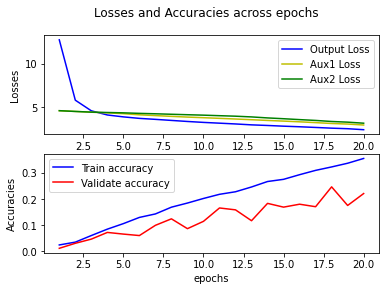

In [ ]:
showLossAccPlots2(train_hist, d=11)

In [ ]:
model_hpt_lr2 = GoogleNet(nclasses=nclasses).model
model_hpt_lr2.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rates[2],
        momentum=0.9
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)

In [ ]:
train_hist = []
hist = model_hpt_lr2.fit(x=X_train, y=[Y_train,Y_train,Y_train], validation_data=(X_validate,[Y_validate,Y_validate,Y_validate]), epochs=epochs, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/20
44/44 [==============================] - 22s 454ms/step - loss: nan - dense_14_loss: nan - aux1_loss: nan - aux2_loss: nan - dense_14_accuracy: 0.0095 - aux1_accuracy: 0.0104 - aux2_accuracy: 0.0091 - val_loss: nan - val_dense_14_loss: nan - val_aux1_loss: nan - val_aux2_loss: nan - val_dense_14_accuracy: 0.0104 - val_aux1_accuracy: 0.0104 - val_aux2_accuracy: 0.0104
Epoch 2/20
44/44 [==============================] - 20s 446ms/step - loss: nan - dense_14_loss: nan - aux1_loss: nan - aux2_loss: nan - dense_14_accuracy: 0.0092 - aux1_accuracy: 0.0092 - aux2_accuracy: 0.0092 - val_loss: nan - val_dense_14_loss: nan - val_aux1_loss: nan - val_aux2_loss: nan - val_dense_14_accuracy: 0.0104 - val_aux1_accuracy: 0.0104 - val_aux2_accuracy: 0.0104
Epoch 3/20
44/44 [==============================] - 19s 439ms/step - loss: nan - dense_14_loss: nan - aux1_loss: nan - aux2_loss: nan - dense_14_accuracy: 0.0092 - aux1_accuracy: 0.0092 - aux2_accuracy: 0.0092 - val_loss: nan - val_dense_

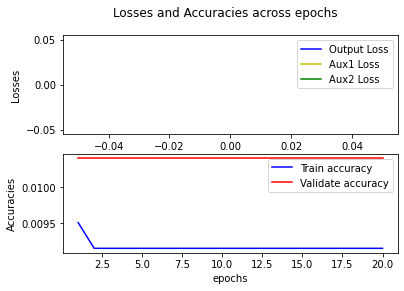

In [ ]:
showLossAccPlots2(train_hist, d=14)

We can see that lr=0.001 yields the most steady rise in performance on the validation set, and also fits the training data comparitively better than the rest. The value 0.1 gives terrible accuracies. Hence we set learning rate = 0.001

In [7]:
learning_rate = 0.001

In [ ]:
momentums = [0.9, 0.75, 0.6]

model_hpt_mt0 = GoogleNet(nclasses).model
model_hpt_mt0.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rate,
        momentum=momentums[0]
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)

In [ ]:
train_hist = []
hist = model_hpt_mt0.fit(x=X_train, y=[Y_train,Y_train,Y_train], validation_data=(X_validate,[Y_validate,Y_validate,Y_validate]), epochs=epochs, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/20
44/44 [==============================] - 23s 483ms/step - loss: 15.1121 - dense_17_loss: 5.7268 - aux1_loss: 4.7168 - aux2_loss: 4.6685 - dense_17_accuracy: 0.0260 - aux1_accuracy: 0.0100 - aux2_accuracy: 0.0092 - val_loss: 13.7787 - val_dense_17_loss: 4.5683 - val_aux1_loss: 4.6056 - val_aux2_loss: 4.6047 - val_dense_17_accuracy: 0.0208 - val_aux1_accuracy: 0.0088 - val_aux2_accuracy: 0.0048
Epoch 2/20
44/44 [==============================] - 21s 467ms/step - loss: 13.7688 - dense_17_loss: 4.5690 - aux1_loss: 4.6001 - aux2_loss: 4.5996 - dense_17_accuracy: 0.0541 - aux1_accuracy: 0.0120 - aux2_accuracy: 0.0124 - val_loss: 13.7285 - val_dense_17_loss: 4.5172 - val_aux1_loss: 4.6069 - val_aux2_loss: 4.6044 - val_dense_17_accuracy: 0.0248 - val_aux1_accuracy: 0.0096 - val_aux2_accuracy: 0.0064
Epoch 3/20
44/44 [==============================] - 20s 458ms/step - loss: 13.4767 - dense_17_loss: 4.2898 - aux1_loss: 4.5921 - aux2_loss: 4.5947 - dense_17_accuracy: 0.0760 - aux1_accu

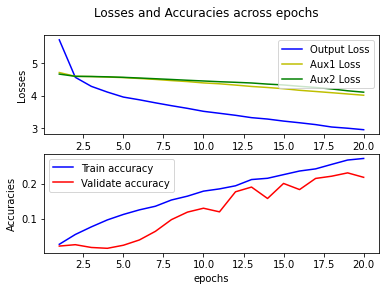

In [ ]:
showLossAccPlots2(train_hist, d=17)

In [ ]:
model_hpt_mt1 = GoogleNet(nclasses).model
model_hpt_mt1.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rate,
        momentum=momentums[1]
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)

In [ ]:
train_hist = []
hist = model_hpt_mt1.fit(x=X_train, y=[Y_train,Y_train,Y_train], validation_data=(X_validate,[Y_validate,Y_validate,Y_validate]), epochs=epochs, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/20
44/44 [==============================] - 23s 471ms/step - loss: 15.3185 - dense_20_loss: 5.8732 - aux1_loss: 4.7870 - aux2_loss: 4.6583 - dense_20_accuracy: 0.0219 - aux1_accuracy: 0.0099 - aux2_accuracy: 0.0086 - val_loss: 13.7967 - val_dense_20_loss: 4.5869 - val_aux1_loss: 4.6051 - val_aux2_loss: 4.6047 - val_dense_20_accuracy: 0.0136 - val_aux1_accuracy: 0.0104 - val_aux2_accuracy: 0.0096
Epoch 2/20
44/44 [==============================] - 21s 470ms/step - loss: 14.0742 - dense_20_loss: 4.8795 - aux1_loss: 4.6017 - aux2_loss: 4.5931 - dense_20_accuracy: 0.0416 - aux1_accuracy: 0.0122 - aux2_accuracy: 0.0142 - val_loss: 13.7608 - val_dense_20_loss: 4.5526 - val_aux1_loss: 4.6041 - val_aux2_loss: 4.6041 - val_dense_20_accuracy: 0.0216 - val_aux1_accuracy: 0.0136 - val_aux2_accuracy: 0.0112
Epoch 3/20
44/44 [==============================] - 20s 461ms/step - loss: 13.7867 - dense_20_loss: 4.6088 - aux1_loss: 4.5926 - aux2_loss: 4.5852 - dense_20_accuracy: 0.0570 - aux1_accu

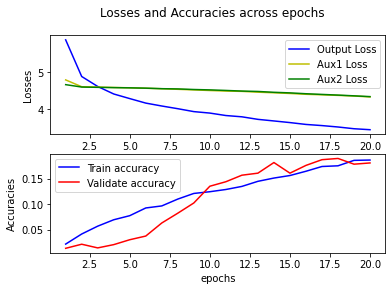

In [ ]:
showLossAccPlots2(train_hist, d=20)

In [ ]:
model_hpt_mt2 = GoogleNet(nclasses).model
model_hpt_mt2.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rate,
        momentum=momentums[2]
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)

In [ ]:
train_hist = []
hist = model_hpt_mt2.fit(x=X_train, y=[Y_train,Y_train,Y_train], validation_data=(X_validate,[Y_validate,Y_validate,Y_validate]), epochs=epochs, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/20
44/44 [==============================] - 23s 470ms/step - loss: 15.4627 - dense_23_loss: 6.0110 - aux1_loss: 4.7799 - aux2_loss: 4.6717 - dense_23_accuracy: 0.0196 - aux1_accuracy: 0.0101 - aux2_accuracy: 0.0089 - val_loss: 13.8037 - val_dense_23_loss: 4.5931 - val_aux1_loss: 4.6058 - val_aux2_loss: 4.6047 - val_dense_23_accuracy: 0.0104 - val_aux1_accuracy: 0.0104 - val_aux2_accuracy: 0.0200
Epoch 2/20
44/44 [==============================] - 20s 463ms/step - loss: 14.3287 - dense_23_loss: 5.1226 - aux1_loss: 4.6101 - aux2_loss: 4.5960 - dense_23_accuracy: 0.0339 - aux1_accuracy: 0.0100 - aux2_accuracy: 0.0141 - val_loss: 13.7858 - val_dense_23_loss: 4.5743 - val_aux1_loss: 4.6062 - val_aux2_loss: 4.6054 - val_dense_23_accuracy: 0.0184 - val_aux1_accuracy: 0.0088 - val_aux2_accuracy: 0.0072
Epoch 3/20
44/44 [==============================] - 20s 463ms/step - loss: 14.0076 - dense_23_loss: 4.8130 - aux1_loss: 4.6044 - aux2_loss: 4.5902 - dense_23_accuracy: 0.0461 - aux1_accu

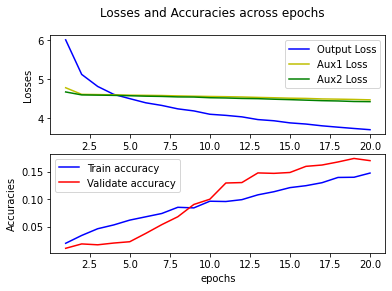

In [ ]:
showLossAccPlots2(train_hist, d=23)

Here we see that the validation accuracy is highest for momentum value of 0.9 and so we will set it accordingly.

In [9]:
momentum = 0.9

MNIST Dataset

In [10]:
(training_data,training_labels),(testing_data,testing_labels) = mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [11]:
training_data = training_data.reshape((training_data.shape[0],28,28,1))
training_labels = training_labels[:, np.newaxis]
testing_data = testing_data.reshape((testing_data.shape[0],28,28,1))
testing_labels = testing_labels[:, np.newaxis]
print(training_data.shape,training_labels.shape,testing_data.shape,testing_labels.shape)

(60000, 28, 28, 1) (60000, 1) (10000, 28, 28, 1) (10000, 1)


In [12]:
# Normalization - check min and max
print(np.min(training_data), np.max(training_data))
print(np.min(testing_data), np.max(testing_data))

0 255
0 255


In [13]:
training_data = training_data.astype('float32') /255.0
testing_data = testing_data.astype('float32') / 255.0

nclasses = len(np.unique(training_labels))

In [14]:
# One-hot encoding for the numeric labels
training_labels = to_categorical(training_labels,num_classes=nclasses)
testing_labels = to_categorical(testing_labels,num_classes=nclasses) 

In [15]:
divide = int(0.1*training_data.shape[0]) # 90-10 split between training and validation sets
X_train = training_data[divide:]
X_validate = training_data[:divide]
Y_train = training_labels[divide:]
Y_validate = training_labels[:divide]
print(X_train.shape,X_validate.shape,Y_train.shape,Y_validate.shape)

(54000, 28, 28, 1) (6000, 28, 28, 1) (54000, 10) (6000, 10)


In [16]:
model_googlenet_mnist = GoogleNet().model
model_googlenet_mnist.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rate,
        momentum=momentum
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)
model_googlenet_mnist.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 64)   3200        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 7, 7, 64)     0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 7, 7, 64)    256         ['max_pooling2d[0][0]']          
 alization)                                                                                   

In [17]:
train_hist = []
hist = model_googlenet_mnist.fit(x=X_train, y=[Y_train,Y_train,Y_train], validation_data=(X_validate,[Y_validate,Y_validate,Y_validate]), epochs=epochs, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/20
211/211 [==============================] - 142s 557ms/step - loss: 3.5639 - dense_2_loss: 1.7931 - aux1_loss: 0.9327 - aux2_loss: 0.8381 - dense_2_accuracy: 0.8171 - aux1_accuracy: 0.7031 - aux2_accuracy: 0.7213 - val_loss: 6.1633 - val_dense_2_loss: 2.1529 - val_aux1_loss: 2.0270 - val_aux2_loss: 1.9834 - val_dense_2_accuracy: 0.4607 - val_aux1_accuracy: 0.5328 - val_aux2_accuracy: 0.5442
Epoch 2/20
211/211 [==============================] - 97s 458ms/step - loss: 0.3737 - dense_2_loss: 0.1155 - aux1_loss: 0.1354 - aux2_loss: 0.1228 - dense_2_accuracy: 0.9678 - aux1_accuracy: 0.9626 - aux2_accuracy: 0.9654 - val_loss: 0.7477 - val_dense_2_loss: 0.1927 - val_aux1_loss: 0.2909 - val_aux2_loss: 0.2641 - val_dense_2_accuracy: 0.9408 - val_aux1_accuracy: 0.9658 - val_aux2_accuracy: 0.9587
Epoch 3/20
211/211 [==============================] - 95s 451ms/step - loss: 0.2546 - dense_2_loss: 0.0833 - aux1_loss: 0.0881 - aux2_loss: 0.0832 - dense_2_accuracy: 0.9765 - aux1_accuracy: 0.

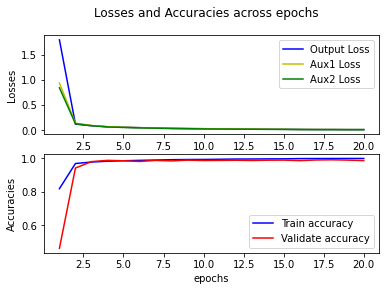

In [19]:
showLossAccPlots2(train_hist, d=2)

In [20]:
# Save the model
model_googlenet_mnist.save('GoogleNetMnist.h5')

In [21]:
model_googlenet_mnist.evaluate(testing_data,[testing_labels,testing_labels,testing_labels],batch_size=batch_size,verbose=1)

40/40 [==============================] - 7s 185ms/step - loss: 0.1304 - dense_2_loss: 0.0506 - aux1_loss: 0.0372 - aux2_loss: 0.0426 - dense_2_accuracy: 0.9877 - aux1_accuracy: 0.9890 - aux2_accuracy: 0.9888


[0.13040311634540558,
 0.05055618658661842,
 0.03722184896469116,
 0.04262508079409599,
 0.9876999855041504,
 0.9890000224113464,
 0.9887999892234802]

Fashion-MNIST Dataset

In [22]:
(training_data,training_labels),(testing_data,testing_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [23]:
training_data = training_data.reshape((training_data.shape[0],28,28,1))
testing_data = testing_data.reshape((testing_data.shape[0],28,28,1))
print(training_data.shape,training_labels.shape,testing_data.shape,testing_labels.shape)

(60000, 28, 28, 1) (60000,) (10000, 28, 28, 1) (10000,)


In [24]:
# Normalization - check min and max
print(np.min(training_data), np.max(training_data))
print(np.min(testing_data), np.max(testing_data))

0 255
0 255


In [25]:
training_data = training_data.astype('float32') /255.0
testing_data = testing_data.astype('float32') / 255.0

nclasses = len(np.unique(training_labels))

In [26]:
# One-hot encoding for the numeric labels
training_labels = to_categorical(training_labels,num_classes=nclasses)
testing_labels = to_categorical(testing_labels,num_classes=nclasses) 

In [27]:
divide = int(0.1*training_data.shape[0]) # 90-10 split between training and validation sets
X_train = training_data[divide:]
X_validate = training_data[:divide]
Y_train = training_labels[divide:]
Y_validate = training_labels[:divide]
print(X_train.shape,X_validate.shape,Y_train.shape,Y_validate.shape)

(54000, 28, 28, 1) (6000, 28, 28, 1) (54000, 10) (6000, 10)


In [28]:
model_googlenet_fashion_mnist = GoogleNet().model
model_googlenet_fashion_mnist.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rate,
        momentum=momentum
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)
model_googlenet_fashion_mnist.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_32 (Conv2D)             (None, 14, 14, 64)   3200        ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_13 (MaxPooling2D  (None, 7, 7, 64)    0           ['conv2d_32[0][0]']              
 )                                                                                                
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 7, 7, 64)    256         ['max_pooling2d_13[0][0]'] 

In [29]:
train_hist = []
hist = model_googlenet_fashion_mnist.fit(x=X_train, y=[Y_train,Y_train,Y_train], validation_data=(X_validate,[Y_validate,Y_validate,Y_validate]), epochs=epochs, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/20
211/211 [==============================] - 97s 453ms/step - loss: 3.0802 - dense_5_loss: 1.1378 - aux1_loss: 0.9693 - aux2_loss: 0.9731 - dense_5_accuracy: 0.7232 - aux1_accuracy: 0.6633 - aux2_accuracy: 0.6541 - val_loss: 5.6119 - val_dense_5_loss: 1.6070 - val_aux1_loss: 2.0035 - val_aux2_loss: 2.0014 - val_dense_5_accuracy: 0.4127 - val_aux1_accuracy: 0.4908 - val_aux2_accuracy: 0.3487
Epoch 2/20
211/211 [==============================] - 95s 450ms/step - loss: 1.3966 - dense_5_loss: 0.5139 - aux1_loss: 0.4404 - aux2_loss: 0.4423 - dense_5_accuracy: 0.8351 - aux1_accuracy: 0.8440 - aux2_accuracy: 0.8446 - val_loss: 1.9507 - val_dense_5_loss: 0.5700 - val_aux1_loss: 0.6923 - val_aux2_loss: 0.6885 - val_dense_5_accuracy: 0.7753 - val_aux1_accuracy: 0.8285 - val_aux2_accuracy: 0.8230
Epoch 3/20
211/211 [==============================] - 95s 450ms/step - loss: 1.1866 - dense_5_loss: 0.4474 - aux1_loss: 0.3699 - aux2_loss: 0.3693 - dense_5_accuracy: 0.8545 - aux1_accuracy: 0.8

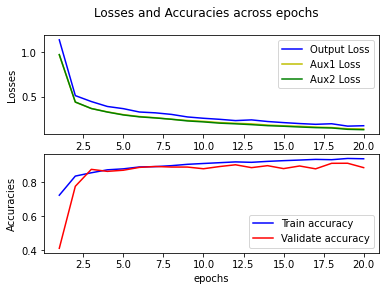

In [30]:
showLossAccPlots2(train_hist, d=5)

In [31]:
# Save the model
model_googlenet_fashion_mnist.save('GoogleNetFashionMnist.h5')

In [32]:
model_googlenet_fashion_mnist.evaluate(testing_data,[testing_labels,testing_labels,testing_labels],batch_size=batch_size,verbose=1)

40/40 [==============================] - 6s 149ms/step - loss: 1.0893 - dense_5_loss: 0.4105 - aux1_loss: 0.3235 - aux2_loss: 0.3552 - dense_5_accuracy: 0.8780 - aux1_accuracy: 0.8898 - aux2_accuracy: 0.8865


[1.0892736911773682,
 0.4105326533317566,
 0.32353919744491577,
 0.3552018702030182,
 0.878000020980835,
 0.8898000121116638,
 0.8865000009536743]

CIFAR-100 Dataset

In [33]:
(training_data,training_labels),(testing_data,testing_labels) = cifar100.load_data()

169001437/169001437 [==============================] - 13s 0us/step


In [34]:
print(training_data.shape,training_labels.shape,testing_data.shape,testing_labels.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [35]:
# Normalization - check min and max
print(np.min(training_data), np.max(training_data))
print(np.min(testing_data), np.max(testing_data))

0 255
0 255


In [36]:
training_data = training_data.astype('float32') /255.0
testing_data = testing_data.astype('float32') / 255.0

nclasses = len(np.unique(training_labels))

In [37]:
# One-hot encoding for the numeric labels
training_labels = to_categorical(training_labels,num_classes=nclasses)
testing_labels = to_categorical(testing_labels,num_classes=nclasses) 

In [38]:
divide = int(0.1*training_data.shape[0]) # 90-10 split between training and validation sets
X_train = training_data[divide:]
X_validate = training_data[:divide]
Y_train = training_labels[divide:]
Y_validate = training_labels[:divide]
print(X_train.shape,X_validate.shape,Y_train.shape,Y_validate.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (45000, 100) (5000, 100)


In [39]:
model_googlenet_cifar100 = GoogleNet(nclasses=nclasses).model
model_googlenet_cifar100.compile(
    optimizer=optimizers.SGD(
        learning_rate=learning_rate,
        momentum=momentum
    ),
        loss=tensorflow.keras.losses.categorical_crossentropy,
        metrics=['accuracy']
)
model_googlenet_cifar100.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_64 (Conv2D)             (None, 16, 16, 64)   9472        ['input_3[0][0]']                
                                                                                                  
 max_pooling2d_26 (MaxPooling2D  (None, 8, 8, 64)    0           ['conv2d_64[0][0]']              
 )                                                                                                
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 8, 8, 64)    256         ['max_pooling2d_26[0][0]'] 

In [40]:
train_hist = []
hist = model_googlenet_cifar100.fit(x=X_train, y=[Y_train,Y_train,Y_train], validation_data=(X_validate,[Y_validate,Y_validate,Y_validate]), epochs=epochs, batch_size=batch_size)
train_hist.append(hist)

Epoch 1/20
176/176 [==============================] - 102s 569ms/step - loss: 13.9844 - dense_8_loss: 4.7726 - aux1_loss: 4.6017 - aux2_loss: 4.6101 - dense_8_accuracy: 0.0577 - aux1_accuracy: 0.0172 - aux2_accuracy: 0.0138 - val_loss: 13.6119 - val_dense_8_loss: 4.4181 - val_aux1_loss: 4.5963 - val_aux2_loss: 4.5975 - val_dense_8_accuracy: 0.0394 - val_aux1_accuracy: 0.0196 - val_aux2_accuracy: 0.0258
Epoch 2/20
176/176 [==============================] - 80s 453ms/step - loss: 12.9923 - dense_8_loss: 3.9797 - aux1_loss: 4.4889 - aux2_loss: 4.5237 - dense_8_accuracy: 0.1140 - aux1_accuracy: 0.0306 - aux2_accuracy: 0.0250 - val_loss: 12.9427 - val_dense_8_loss: 3.9281 - val_aux1_loss: 4.4962 - val_aux2_loss: 4.5184 - val_dense_8_accuracy: 0.1098 - val_aux1_accuracy: 0.0430 - val_aux2_accuracy: 0.0414
Epoch 3/20
176/176 [==============================] - 80s 453ms/step - loss: 12.5336 - dense_8_loss: 3.7135 - aux1_loss: 4.3888 - aux2_loss: 4.4312 - dense_8_accuracy: 0.1499 - aux1_accurac

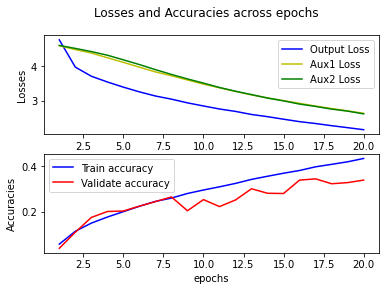

In [41]:
showLossAccPlots2(train_hist, d=8)

In [42]:
# Save the model
model_googlenet_cifar100.save('GoogleNetCifar100.h5')

In [43]:
model_googlenet_cifar100.evaluate(testing_data,[testing_labels,testing_labels,testing_labels],batch_size=128,verbose=1)

79/79 [==============================] - 11s 104ms/step - loss: 8.2543 - dense_8_loss: 2.6637 - aux1_loss: 2.8014 - aux2_loss: 2.7892 - dense_8_accuracy: 0.3580 - aux1_accuracy: 0.2928 - aux2_accuracy: 0.2920


[8.254331588745117,
 2.6637353897094727,
 2.8013880252838135,
 2.7892098426818848,
 0.3580000102519989,
 0.29280000925064087,
 0.2919999957084656]